### GPU, cuda, gccの確認


In [1]:
!nvidia-smi
!nvcc --version
!gcc --version

Fri Dec  5 05:48:58 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.274.02             Driver Version: 535.274.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8              10W /  90W |      8MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### パッケージのインストール / クリーンインストール
ssh先のjupyter環境などで実行の場合は, 当該環境にパッケージをインストール

In [2]:
# クリーンが必要であれば実行
!rm -rf kineticEQ
#!rm -rf build

In [3]:
# インストール
!git clone https://github.com/Minamium/kineticEQ.git
!pip install -e ./kineticEQ

Cloning into 'kineticEQ'...
remote: Enumerating objects: 1603, done.
remote: Counting objects: 100% (405/405), done.
remote: Compressing objects: 100% (230/230), done.
remote: Total 1603 (delta 215), reused 323 (delta 141), pack-reused 1198 (from 1)
Receiving objects: 100% (1603/1603), 7.56 MiB | 16.10 MiB/s, done.
Resolving deltas: 100% (838/838), done.
Obtaining file:///home/arlm/workspace/kineticEQ
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for kineticEQ (pyproject.toml) ... done
  Created wheel for kineticEQ: filename=kineticeq-0.4.0-0.editable-py3-none-any.whl size=2710 sha256=f84d00eae89fc236f5aa13f13ea1cef30916e6a4584de06724eb86bda810b6f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-4w80pped/wheels/5c/8f/4c/777f8eab2b3d762127884b756300580189ab20868ab32d31f6
Successfully built kineticEQ
  Atte

### 動作確認

--- auto compile ---
--- compile cuSOLVER ---


Detected CUDA files, patching ldflags
Emitting ninja build file build/build.ninja...
/home/arlm/workspace/venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module gtsv_batch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF gtsv_binding.o.d -DTORCH_EXTENSION_NAME=gtsv_batch -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -I/usr/include/python3.12 -isystem /home/arlm/workspace/venv/lib/python3.12/site-packages/torch/include -isystem /home/arlm/workspace/venv/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda-12.6/include -isystem /usr/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -O3 -c /home/arlm/workspace/kineticEQ/src/kineticEQ/backends/gtsv/gtsv_binding.cpp -o gtsv_binding.o 
[2/3] /usr/local/cuda-12.6/bin/nvcc --generate-dependencies-with-compile --dependency-output gtsv_batch.cuda.o.d -DTORCH_EXTENSION_NAME=gtsv_batch -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -I/usr/include/python3.12 -isystem /home/arlm/workspace/venv/lib/python3.12/site-packages

Loading extension module gtsv_batch...
Detected CUDA files, patching ldflags
Emitting ninja build file build/build.ninja...
Building extension module lo_blocktridiag...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF block_tridiag_binding.o.d -DTORCH_EXTENSION_NAME=lo_blocktridiag -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -I/usr/include/python3.12 -isystem /home/arlm/workspace/venv/lib/python3.12/site-packages/torch/include -isystem /home/arlm/workspace/venv/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda-12.6/include -isystem /usr/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -O3 -c /home/arlm/workspace/kineticEQ/src/kineticEQ/backends/lo_blocktridiag/block_tridiag_binding.cpp -o block_tridiag_binding.o 
[2/3] /usr/local/cuda-12.6/bin/nvcc --generate-dependencies-with-compile --dependency-output block_tridiag_kernel.cuda.o.d -DTORCH_EXTENSION_NAME=lo_blocktridiag -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -I/usr/include/python3.12 -isys

Loading extension module lo_blocktridiag...
NoneType: None


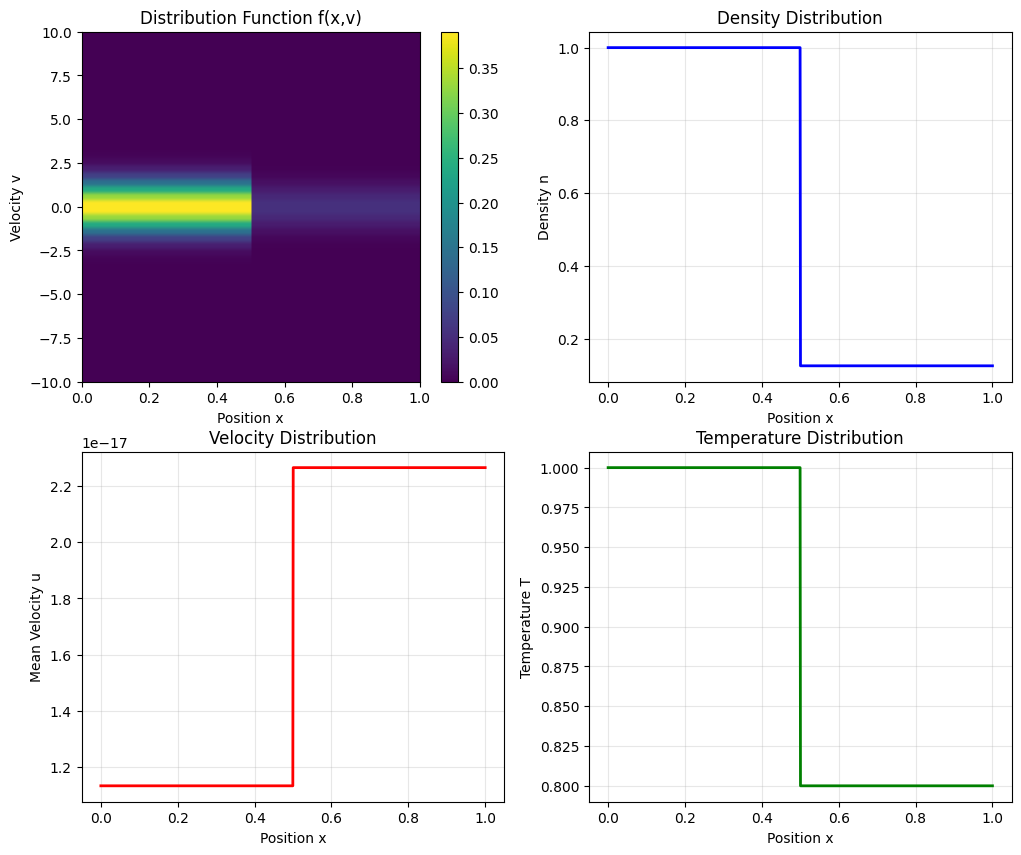

Density: mean=0.5625, min=0.1250, max=1.0000
Velocity: mean=0.0000, min=0.0000, max=0.0000
Temperature: mean=0.9000, min=0.8000, max=1.0000
--- run simulation ---
--- Starting implicit time evolution ---
CFL number: 4.9950


Implicit Evolution:   0%|          | 0/101 [00:00<?, ?it/s]

Step     0/100 (t=0.000)
Picard iteration:     3, residual: 4.819264e-11
LO iteration: [16, 16, 16], residual: [6.474403234368875e-07, 6.474074248641326e-07, 6.474074251139328e-07]


Implicit Evolution:   9%|▉         | 9/101 [00:00<00:07, 12.08it/s]

Step    10/100 (t=0.005)
Picard iteration:     2, residual: 9.422257e-07
LO iteration: [20, 20], residual: [8.34188620374432e-07, 8.341878522388768e-07]


Implicit Evolution:  19%|█▉        | 19/101 [00:01<00:04, 16.98it/s]

Step    20/100 (t=0.010)
Picard iteration:     2, residual: 9.563962e-07
LO iteration: [20, 20], residual: [6.005643878592704e-07, 6.005726897739816e-07]


Implicit Evolution:  29%|██▊       | 29/101 [00:01<00:04, 15.96it/s]

Step    30/100 (t=0.015)
Picard iteration:     3, residual: 7.674784e-12
LO iteration: [19, 19, 19], residual: [7.223961472624385e-07, 7.223923227661633e-07, 7.223923225163631e-07]


Implicit Evolution:  39%|███▊      | 39/101 [00:02<00:04, 13.14it/s]

Step    40/100 (t=0.020)
Picard iteration:     3, residual: 7.832922e-12
LO iteration: [19, 19, 19], residual: [8.449760471596068e-07, 8.449855335157519e-07, 8.449855327663514e-07]


Implicit Evolution:  49%|████▊     | 49/101 [00:03<00:04, 12.79it/s]

Step    50/100 (t=0.025)
Picard iteration:     3, residual: 6.465703e-12
LO iteration: [19, 19, 19], residual: [6.074998291361045e-07, 6.0751695676875e-07, 6.075169559083271e-07]


Implicit Evolution:  58%|█████▊    | 59/101 [00:04<00:03, 12.73it/s]

Step    60/100 (t=0.030)
Picard iteration:     3, residual: 7.805985e-12
LO iteration: [19, 19, 19], residual: [7.855744338924886e-07, 7.855783548949002e-07, 7.85578354450811e-07]


Implicit Evolution:  68%|██████▊   | 69/101 [00:05<00:02, 12.72it/s]

Step    70/100 (t=0.035)
Picard iteration:     3, residual: 6.455426e-12
LO iteration: [19, 19, 19], residual: [7.255099405689691e-07, 7.2552383803548e-07, 7.255238372583239e-07]


Implicit Evolution:  78%|███████▊  | 79/101 [00:05<00:01, 12.74it/s]

Step    80/100 (t=0.040)
Picard iteration:     3, residual: 7.347949e-12
LO iteration: [19, 19, 19], residual: [6.66899305834523e-07, 6.668971688772452e-07, 6.668971685996894e-07]


Implicit Evolution:  88%|████████▊ | 89/101 [00:06<00:00, 12.82it/s]

Step    90/100 (t=0.045)
Picard iteration:     3, residual: 7.443747e-12
LO iteration: [19, 19, 19], residual: [7.798393812374904e-07, 7.798484752408186e-07, 7.798484746857071e-07]


Implicit Evolution:  98%|█████████▊| 99/101 [00:07<00:00, 12.78it/s]

Step   100/100 (t=0.050)
Picard iteration:     3, residual: 6.278408e-12
LO iteration: [18, 18, 18], residual: [9.805815265606643e-07, 9.806067725603995e-07, 9.806067711171096e-07]


Implicit Evolution: 100%|██████████| 101/101 [00:07<00:00, 13.32it/s]

Time evolution completed!
--- run simulation complete, Result is saved in self.f ---


<Figure size 640x480 with 0 Axes>

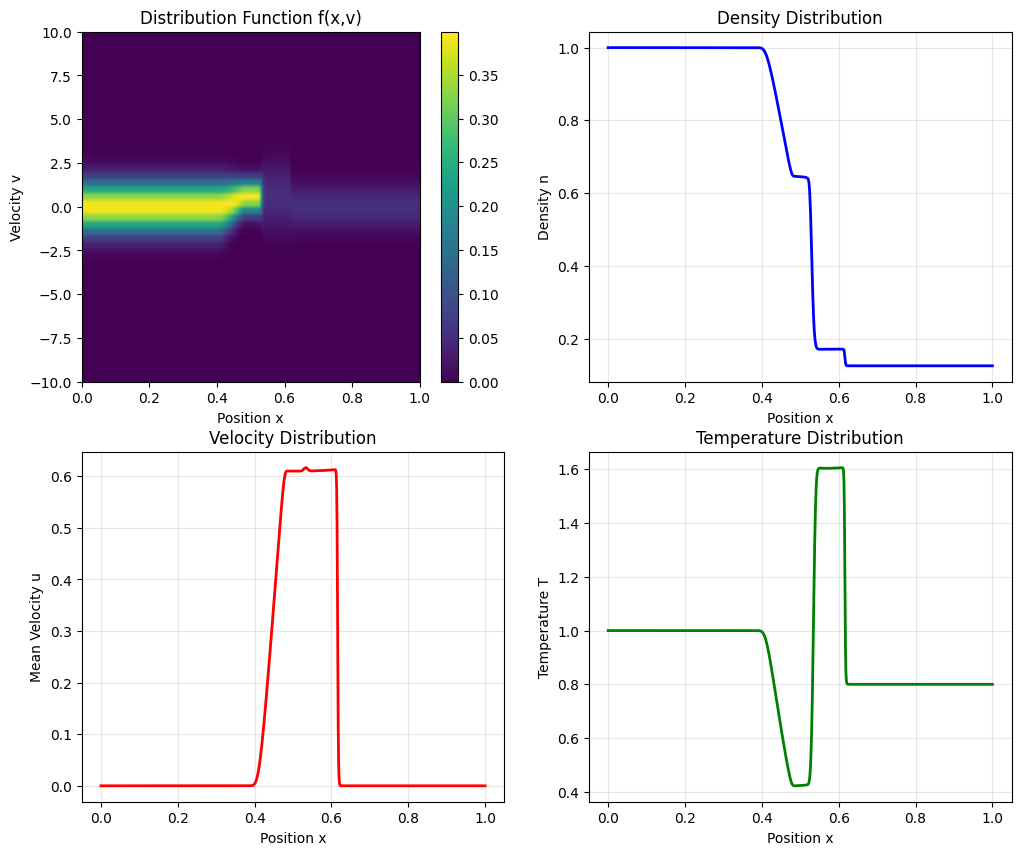

Density: mean=0.5625, min=0.1250, max=1.0000
Velocity: mean=0.1050, min=-0.0000, max=0.6167
Temperature: mean=0.9194, min=0.4223, max=1.6063
Creating GIF with 11 frames...
  Frame 3/11 processed
  Frame 6/11 processed
  Frame 9/11 processed
GIF saved: 'base_bench.gif' (11 frames)


<Figure size 640x480 with 0 Axes>

In [4]:
# import packages
%run kineticEQ/tests/base/base_test.py --nv 50 --T_total 0.05 --tau_tilde 5e-9 --dt 5e-4 --lo_iter 64 --lo_tol 1e-6 --ho_iter 64 --ho_tol 1e-6